<a href="https://colab.research.google.com/github/escape-capstone-design/NLP/blob/seungeun/warmup20_epoch60.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install sentence_transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=542720f54d70525a4addb9a145dd5e2

In [3]:
# import

import random
import math
import numpy as np
import logging
from datetime import datetime
import pandas as pd
import os
import csv
from typing import List, Union
from tqdm.autonotebook import trange

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util, SentencesDataset
from sentence_transformers.evaluation import SentenceEvaluator, TripletEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

<ipython-input-3-a0c2e556e394>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# dataset

In [4]:
# wa3i 프로젝트 데이터
wa3i_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/종설/science_wai.csv')
wa3i_data = wa3i_data.dropna(how='any')
wa3i_data

,sentence1,sentence2,gold_label
0,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자가 먹을 것이 없어 죽게되고 분해자도 소비자가 다 죽어 소비자...,entailment
1,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 생태계에 없으면 소비자와 분해자가 먹을것을 못먹는다.못먹는 소비자와 분해자...,entailment
2,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 있지 않으면 생산자를 먹는 동물도 그 동물을 먹는 동물도 굶게 되어 생태계...,entailment
3,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자는 소비자와 분해자들에게 영양을 제공한다. 만약 생산자가 없다면 소비자는 영양...,entailment
4,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다,entailment
...,...,...,...
8721,부력에 의해 배를 띄울 수 있다.,물이 힘이있어서,contradiction
8722,부력에 의해 배를 띄울 수 있다.,파도를 이용하여 뜨게 하는것 같다,contradiction
8723,부력에 의해 배를 띄울 수 있다.,물체를 띄우는 힘인 부력을 활용한 것이다.,entailment
8724,부력에 의해 배를 띄울 수 있다.,배는 부력의 원리로 뜨기 때문에 물을 사용하면 쉽게 이동시킬 수 있다.,entailment


In [5]:
# 직접 수집한 데이터
custom_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/종설/science_workbook_custom.csv')
custom_data = custom_data.dropna(how='any')
custom_data

,sentence1,sentence2,gold_label
0,"중력의 크기는 질량에 비례하고, 자유 낙하 운동에서 낙하 시간은 높이에 의해 결정된다.",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
1,"중력 크기는 질량과 관련되어 있으며, 자유 낙하로 이동하는데 걸리는 시간은 출발 지...",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
2,"중력 작용은 물체의 무게와 관련이 있고, 자유 낙하 동안 걸리는 시간은 높이에 좌우된다.",중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
3,중력은 질량에 의해 결정되며 낙하 운동에서 높이는 낙하 시간을 결정하는 중요한 요소...,중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
4,물체의 질량이 증가하면 중력의 힘도 증가합니다 낙하 운동에서 높이가 낮으면 물체가 ...,중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은...,entailment
...,...,...,...
6389,"높이가 같은 상태에서 자유 낙하한 물체와 수평으로 던진 물체는 동시에 도착하며, 중...","같은 높이에서 자유 낙하한 쇠구슬은 바닥에 도달했지만, 수평으로 던진 쇠구슬은 아직...",contradiction
6390,"같은 높이에서 자유 낙하한 물체와 수평으로 던진 물체는 동시에 도착하며, 중력은 연...",같은 높이에서 자유 낙하한 쇠구슬과 수평으로 던진 쇠구슬은 동시에 도달하였다. 두 ...,entailment
6391,"같은 높이에서 자유 낙하한 물체와 수평으로 던진 물체는 동시에 도착하며, 중력은 연...","같은 높이에서 자유 낙하한 쇠구슬은 바닥에 도달했지만, 수평으로 던진 쇠구슬은 아직...",contradiction
6392,"높이가 같은 상태에서 자유 낙하한 물체와 수평으로 던진 물체는 동시에 도착하는데, ...",같은 높이에서 자유 낙하한 쇠구슬과 수평으로 던진 쇠구슬은 동시에 도달하였다. 두 ...,entailment


In [6]:
# transform to Triplet format

def make_nli_triplet_wa3i(dataset):
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = row['gold_label'].strip()

        add_to_samples(sent1, sent2, label)

    # transform to InputExamples
    added_triplets = set()  # Set to keep track of added triplets
    input_examples=[]
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            entailment_list = list(others['entailment'])
            contradiction_list = list(others['contradiction'])

            # Shuffle the lists to randomize the selection
            random.shuffle(entailment_list)
            random.shuffle(contradiction_list)

            # Use the same anchor for multiple triplets
            anchor = sent1

            for _ in range(15):  # Adjust the number of triplets as needed
                ent = random.choice(entailment_list)
                con = random.choice(contradiction_list)

                 # Check if the triplet is not already in the set
                triplet = (anchor, ent, con)
                if triplet not in added_triplets:
                    input_examples.append(InputExample(texts=[anchor, ent, con]))
                    added_triplets.add(triplet)
    print(len(added_triplets))
    print(len(input_examples))
    return input_examples

In [7]:
def make_nli_triplet_custom(dataset):
    # transform to Triplet format
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = str(row['gold_label']).strip()

        add_to_samples(sent1, sent2, label)
        add_to_samples(sent2, sent1, label)  # Also add the opposite

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            input_examples.append(InputExample(texts=[sent1, random.choice(list(others['entailment'])), random.choice(list(others['contradiction']))]))
            input_examples.append(InputExample(texts=[random.choice(list(others['entailment'])), sent1, random.choice(list(others['contradiction']))]))

    return input_examples

In [8]:
wa3i_dataset = make_nli_triplet_wa3i(wa3i_data)
wa3i_dataset[0].texts

1452
1452


['생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계의 소비자도 먹이가 없어서 죽게 되어 생태계의 균형이 깨진다.',
 '생산자가 없어지면 생물도 없어지기 때문이다.',
 '이산화탄소를 산소로 바꿔줘야하기 때문이다']

In [9]:
custom_dataset = make_nli_triplet_custom(custom_data)
custom_dataset[0].texts

['중력의 크기는 질량에 비례하고, 자유 낙하 운동에서 낙하 시간은 높이에 의해 결정된다.',
 '중력의 크기는 질량에 비례하므로 무거운 물체일수록 큰 중력을 경험한다. 낙하 시간은 높이에 따라 결정된다.',
 '중력의 크기는 질량에 비례하며, 자유 낙하 운동에서 낙하 시간은 높이와 상관없이 동일하다.']

In [10]:
print(f'triplet wa3i: {len(wa3i_dataset)}')
print(f'triplet custom: {len(custom_dataset)}')

triplet wa3i: 1452
triplet custom: 4724


In [11]:
# (wa3i dataset) 6:2:2 split

dataset_size = len(wa3i_dataset)
wa3i_train_size = int(dataset_size * 0.6)
wa3i_validation_size = int(dataset_size * 0.2)
wa3i_test_size = dataset_size - wa3i_train_size - wa3i_validation_size

wa3i_train, wa3i_valid, wa3i_test = random_split(wa3i_dataset, [wa3i_train_size, wa3i_validation_size, wa3i_test_size])

print(f"Training Data Size : {len(wa3i_train)}")
print(f"Validation Data Size : {len(wa3i_valid)}")
print(f"Testing Data Size : {len(wa3i_test)}")

Training Data Size : 871
Validation Data Size : 290
Testing Data Size : 291


In [12]:
# (custom dataset) 6:2:2 split

dataset_size = len(custom_dataset)
custom_train_size = int(dataset_size * 0.6)
custom_validation_size = int(dataset_size * 0.2)
custom_test_size = dataset_size - custom_train_size - custom_validation_size

custom_train, custom_valid, custom_test = random_split(custom_dataset, [custom_train_size, custom_validation_size, custom_test_size])

print(f"Training Data Size : {len(custom_train)}")
print(f"Validation Data Size : {len(custom_valid)}")
print(f"Testing Data Size : {len(custom_test)}")

Training Data Size : 2834
Validation Data Size : 944
Testing Data Size : 946


In [13]:
# merge dataset

train_dataset = wa3i_train + custom_train
validation_dataset = wa3i_valid + custom_valid
test_dataset = wa3i_test + custom_test
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 3705
Validation Data Size : 1234
Testing Data Size : 1237


# evaluator

In [14]:
# Evaluator by train
train_evaluator = TripletEvaluator.from_input_examples(
    train_dataset,
    name="train-evaluator",
)

# Evaluator by validation
valid_evaluator = TripletEvaluator.from_input_examples(
    validation_dataset,
    name="valid-evaluator",
)

# Evaluator by test
test_evaluator = TripletEvaluator.from_input_examples(
    test_dataset,
    name="test-evaluator",
)


In [15]:
# get loss value

logger = logging.getLogger(__name__)


class LossEvaluator(SentenceEvaluator):

    def __init__(self, loader, loss_model: nn.Module = None, name: str = '', log_dir: str = None,
                 show_progress_bar: bool = False, write_csv: bool = True):

        """
        Evaluate a model based on the loss function.
        The returned score is loss value.
        The results are written in a CSV and Tensorboard logs.
        :param loader: Data loader object
        :param loss_model: loss module object
        :param name: Name for the output
        :param log_dir: path for tensorboard logs
        :param show_progress_bar: If true, prints a progress bar
        :param write_csv: Write results to a CSV file
        """

        self.loader = loader
        self.write_csv = write_csv
        self.logs_writer = SummaryWriter(log_dir=log_dir)
        self.name = name
        self.loss_model = loss_model

        # move model to gpu:  lidija-jovanovska
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        loss_model.to(self.device)

        if show_progress_bar is None:
            show_progress_bar = (
                    logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "loss_evaluation" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "loss"]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        self.loss_model.eval()

        loss_value = 0
        self.loader.collate_fn = model.smart_batching_collate
        num_batches = len(self.loader)
        data_iterator = iter(self.loader)

        with torch.no_grad():
          for _ in trange(num_batches, desc="Iteration", smoothing=0.05, disable=not self.show_progress_bar):
              sentence_features, labels = next(data_iterator)
              # move data to gpu
              for i in range(0, len(sentence_features)):
                  for key, value in sentence_features[i].items():
                      sentence_features[i][key] = sentence_features[i][key].to(self.device)
              labels = labels.to(self.device)
              loss_value += self.loss_model(sentence_features, labels).item()

        final_loss = loss_value / num_batches
        if output_path is not None and self.write_csv:

            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)

            with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, final_loss])

            # ...log the running loss
            self.logs_writer.add_scalar('val_loss',
                                        final_loss,
                                        steps)

        self.loss_model.zero_grad()
        self.loss_model.train()

        return final_loss

# model

In [16]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path="BM-K/KoSimCSE-roberta-multitask",
    max_seq_length=869,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])


In [17]:
# config
num_epochs = 60
batch_size = 16

In [18]:
train_dataset = SentencesDataset(train_dataset, model=model)

# Train / Valid Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# warmup steps
warmup_steps = math.ceil(len(train_dataset) * 20 / 16 * 0.5) #50% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))
print(warmup_steps)

2316


In [22]:
# train model
pretrained_model_name = "KoSimCSE-roberta"
model_save_path = 'output/' + pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use ContrastiveLoss
loss_func = losses.TripletLoss(model)

epochs = []
train_list = []
valid_list = []
test_list = []
train_loss_history = []
valid_loss_history = []

# loss evaluator
train_loss_evaluator = LossEvaluator(train_dataloader, loss_model=loss_func, log_dir='logs/', name='train')
valid_loss_evaluator = LossEvaluator(valid_dataloader, loss_model=loss_func, log_dir='logs/', name='valid')

# Training
for epoch in range(num_epochs):
    print(f'{epoch} epoch')
    epochs.append(epoch)
    model.fit(
              train_objectives=[(train_dataloader, loss_func)],
              evaluator=valid_evaluator,
              epochs=1,
              evaluation_steps=int(len(train_dataloader)*0.1),
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              use_amp=False      #Set to True, if your GPU supports FP16 operations
    )

    train = train_evaluator(model)
    train_list.append(train)
    print(f'train => {train}')

    valid = valid_evaluator(model)
    valid_list.append(valid)
    print(f'valid => {valid}')

    # todo: test 데이터 사용 시 주석 해제
    # test = test_evaluator(model)
    # test_list.append(test)
    # print(f'test => {test}')

    train_loss = train_loss_evaluator(model)
    train_loss_history.append(train_loss)
    print(f'train_loss => {train_loss}')

    valid_loss = valid_loss_evaluator(model)
    valid_loss_history.append(valid_loss)
    print(f'valid_loss => {valid_loss}')

0 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9522267206477733
valid => 0.9513776337115073
train_loss => 0.7940840719845789
valid_loss => 0.8256034598900721
1 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9719298245614035
valid => 0.9724473257698542
train_loss => 0.5213976400936472
valid_loss => 0.5537757522020584
2 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9800269905533063
valid => 0.9781199351701783
train_loss => 0.3891360989033148
valid_loss => 0.4384434001568036
3 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9870445344129555
valid => 0.9837925445705025
train_loss => 0.26992080482686387
valid_loss => 0.3506916392690096
4 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.99055330634278
valid => 0.9870340356564019
train_loss => 0.19783781491348457
valid_loss => 0.2884886604853166
5 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9946018893387314
valid => 0.9910858995137763
train_loss => 0.14757113897337995
valid_loss => 0.2517388952084077
6 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9954116059379218
valid => 0.9918962722852512
train_loss => 0.10761405912966564
valid_loss => 0.2250043898820877
7 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.996221322537112
valid => 0.9910858995137763
train_loss => 0.08406381745790613
valid_loss => 0.2102590554799789
8 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9970310391363023
valid => 0.9927066450567261
train_loss => 0.06654337009993093
valid_loss => 0.19791257668
9 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9975708502024292
valid => 0.9943273905996759
train_loss => 0.05186697994840556
valid_loss => 0.1844745832375991
10 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9978407557354926
valid => 0.993517017828201
train_loss => 0.043737527753772404
valid_loss => 0.17937276512384415
11 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9978407557354926
valid => 0.9927066450567261
train_loss => 0.036908488945457445
valid_loss => 0.17342133877369073
12 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.998110661268556
valid => 0.993517017828201
train_loss => 0.028199972392156207
valid_loss => 0.16448213580327156
13 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9983805668016195
valid => 0.9927066450567261
train_loss => 0.025077320378402185
valid_loss => 0.16066635495577103
14 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9983805668016195
valid => 0.9918962722852512
train_loss => 0.021655417464930434
valid_loss => 0.15722248149223816
15 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9986504723346828
valid => 0.9927066450567261
train_loss => 0.01807409113851087
valid_loss => 0.14675195687092268
16 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9989203778677462
valid => 0.9951377633711507
train_loss => 0.016474393935039126
valid_loss => 0.1363065282885845
17 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9989203778677462
valid => 0.9943273905996759
train_loss => 0.014932624481875321
valid_loss => 0.1432779289973088
18 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9989203778677462
valid => 0.9943273905996759
train_loss => 0.011889805439217338
valid_loss => 0.1394853081840735
19 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.01035304329004781
valid_loss => 0.13790342861261123
20 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.00870580380332881
valid_loss => 0.1375574549803367
21 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.008164431514411137
valid_loss => 0.1357570292475896
22 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.007271031238909425
valid_loss => 0.13809683460455674
23 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.007980755690870613
valid_loss => 0.13473976651827493
24 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006963984719638167
valid_loss => 0.13658243742508766
25 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.007903656055187357
valid_loss => 0.13337524636433676
26 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006801295383223172
valid_loss => 0.13220592912955162
27 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006440263113071178
valid_loss => 0.1332494215323375
28 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.006533304935899274
valid_loss => 0.13081959004585558
29 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006560485167749997
valid_loss => 0.12727367667815623
30 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.006842622212294875
valid_loss => 0.12526324945382583
31 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006572586195222263
valid_loss => 0.1232313586351199
32 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.006617732217599605
valid_loss => 0.12511393695305556
33 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.006203300737101456
valid_loss => 0.1255838529039652
34 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.005891762288479969
valid_loss => 0.1252862986845848
35 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.006223674992035176
valid_loss => 0.13244018932947746
36 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.006241205052055162
valid_loss => 0.12917427928783956
37 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.0059895268801985115
valid_loss => 0.12250653768961246
38 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9918962722852512
train_loss => 0.006343409419059753
valid_loss => 0.13731316515268424
39 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9927066450567261
train_loss => 0.006391669655668324
valid_loss => 0.12453159307822204
40 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.0059240790533608405
valid_loss => 0.12013768156369527
41 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.006654803095192745
valid_loss => 0.12050448281642719
42 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9959481361426256
train_loss => 0.006503992039581825
valid_loss => 0.11729586869478226
43 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.006474515615866102
valid_loss => 0.1167761838206878
44 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.005671464805972987
valid_loss => 0.11562596185085101
45 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005924889368229899
valid_loss => 0.11664213603123641
46 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9959481361426256
train_loss => 0.005266303260778558
valid_loss => 0.1174106124119881
47 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005835059131013936
valid_loss => 0.11061442184906739
48 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005614134900528809
valid_loss => 0.11232327803587303
49 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005961925305169204
valid_loss => 0.11245366854545398
50 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.005813752397381026
valid_loss => 0.11381038221029136
51 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.00569747105754655
valid_loss => 0.10904163255905494
52 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9927066450567261
train_loss => 0.005365709035561003
valid_loss => 0.10895984830000462
53 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.00517570805446855
valid_loss => 0.11196804772584866
54 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005503474638379854
valid_loss => 0.11117738408920093
55 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.005489402418506557
valid_loss => 0.22349464702300537
56 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.993517017828201
train_loss => 0.0052638665355485064
valid_loss => 0.11186514890346771
57 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9927066450567261
train_loss => 0.005410128240955287
valid_loss => 0.11754423800187233
58 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9943273905996759
train_loss => 0.005242799119702701
valid_loss => 0.11266868313153584
59 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/232 [00:00<?, ?it/s]

train => 0.9991902834008097
valid => 0.9951377633711507
train_loss => 0.005636920959785067
valid_loss => 0.11498336436656806


# result

In [23]:
# evaluation valid
valid_evaluator(model, output_path=model_save_path)

0.9951377633711507

In [ ]:
# todo: test 데이터 사용 시 주석 해제
# evaluation test
# test_evaluator(model, output_path=model_save_path)

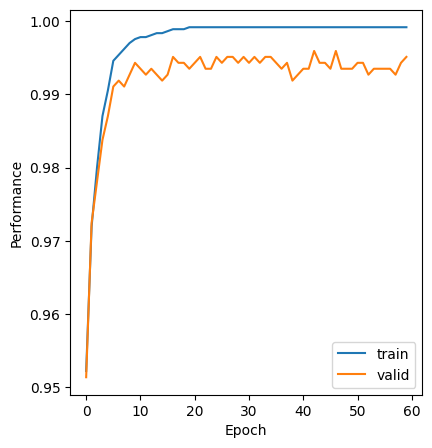

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.legend()
plt.show()

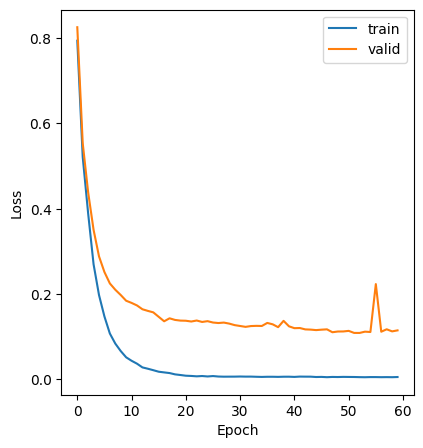

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, train_loss_history, label='train')
plt.plot(epochs, valid_loss_history, label='valid')
plt.legend()
plt.show()

In [26]:
# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승한다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: 0.9172


In [27]:
# 문장을 정의
sentence1 = "삼십대의 비율은 감소한다."
sentence2 = "삼십대의 비율은 증가하게된다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

첫 번째 문장과 두 번째 문장의 코사인 유사도: -0.1212



#Test

In [28]:
# 빈 리스트를 생성하여 원래 데이터셋 형식으로 변환된 데이터를 저장
nli_test_data = []

# 각 트리플릿을 원래 데이터셋 형식으로 변환
for input_example in test_dataset:
    anchor_sentence = input_example.texts[0]
    positive_sentence = input_example.texts[1]
    negative_sentence = input_example.texts[2]

    # 긍정적 예를 1로 레이블링
    nli_test_data.append({'sentence1': anchor_sentence, 'sentence2': positive_sentence, 'gold_label': 1})

    # 부정적 예를 0으로 레이블링
    nli_test_data.append({'sentence1': anchor_sentence, 'sentence2': negative_sentence, 'gold_label': 0})

# original_format_data에는 원래 데이터셋 형식으로 변환된 데이터가 저장됨

In [29]:

import pandas as pd


# https://wikidocs.net/154530
import numpy as np
import pandas as pd
import urllib.request
from sentence_transformers import SentenceTransformer

sbert_kor = SentenceTransformer('/content/output/KoSimCSE-roberta-2023-11-08_10-59-42')

from numpy import dot
from numpy.linalg import norm


def get_similarity(ans, right_ans, use="cosine"):
    # Cosine Similarity
    if use == "cosine":
        return dot(ans, right_ans) / (norm(ans) * norm(right_ans))

    # Euclidean
    if use == "euclidean":
        if norm(ans - right_ans) == norm(ans - right_ans):
            return norm(ans - right_ans)
        else:
            return -1

    # Pearson
    if use == "pearson":
        return dot((ans - np.mean(ans)), (right_ans - np.mean(right_ans))) / (
                    (norm(ans - np.mean(ans))) * (norm(right_ans - np.mean(right_ans))))




nli_test_data
# original_format_data 리스트를 Pandas 데이터프레임으로 변환
nli_test_data = pd.DataFrame(nli_test_data)
prediction = []
for data in nli_test_data.iloc:
    right_ans = data['sentence1']
    student_ans = data['sentence2']
    label = data['gold_label']
    # print(right_ans, '//', student_ans, '//', label)

    right_ans_emb = sbert_kor.encode([right_ans])
    stu_ans_emb = sbert_kor.encode([student_ans])

    sim = get_similarity(right_ans_emb[0], stu_ans_emb[0], use="cosine")
    prediction.append(sim)

nli_test_data['predict(cosine_sim)'] = prediction


# %%

def threshhold_num(n=0.6):
    def threshold(pred):
        if pred > n:
            return 1
        elif pred <= n:
            return 0

    return threshold

nli_test_data['>0.6'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.6))
nli_test_data['>0.7'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.7))
nli_test_data['>0.8'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.8))
nli_test_data['>0.9'] = nli_test_data['predict(cosine_sim)'].apply(threshhold_num(0.9))
# df_valid_v1.head(50)

# %%

nli_test_data.to_csv('./test.csv')

# %%
def get_acc(thresh):
    cnt = 0
    for idx in range(len(nli_test_data)):
      if nli_test_data['gold_label'][idx] == nli_test_data[f'>{thresh}'][idx]:
        cnt += 1
    print("threshold",thresh," accuracy:",cnt / len(nli_test_data))

get_acc(0.6)
get_acc(0.7)
get_acc(0.8)
get_acc(0.9)


threshold 0.6  accuracy: 0.9797898140662894
threshold 0.7  accuracy: 0.965642683912692
threshold 0.8  accuracy: 0.9223928860145514
threshold 0.9  accuracy: 0.7837510105092966


정밀도: 0.9805668016194332
재현율: 0.978981406628941
F1 점수: 0.9797734627831715
혼동 행렬:
 [[1213   24]
 [  26 1211]]


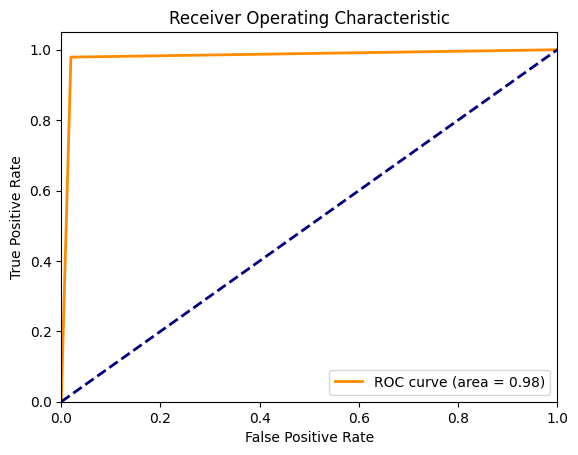

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 레이블과 실제 레이블 가져오기
predicted_labels = nli_test_data['>0.6']  # 이진 분류 예측 레이블
true_labels = nli_test_data['gold_label']

# 정밀도 계산
precision = precision_score(true_labels, predicted_labels)

# 재현율 계산
recall = recall_score(true_labels, predicted_labels)

# F1 점수 계산
f1 = f1_score(true_labels, predicted_labels)

# 혼동 행렬 생성
confusion = confusion_matrix(true_labels, predicted_labels)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 점수:", f1)
print("혼동 행렬:\n", confusion)

# 실제 레이블과 예측 확률을 사용하여 ROC 곡선 및 AUC 값을 계산
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_labels)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [31]:
# 0.6
predicted_labels = nli_test_data['>0.6']
true_labels = nli_test_data['gold_label']

confusion = confusion_matrix(true_labels, predicted_labels)
print("threshold 0.6 혼동 행렬:\n", confusion)

# 0.7
predicted_labels = nli_test_data['>0.7']
true_labels = nli_test_data['gold_label']

confusion = confusion_matrix(true_labels, predicted_labels)
print("threshold 0.7 혼동 행렬:\n", confusion)

# 0.8
predicted_labels = nli_test_data['>0.8']
true_labels = nli_test_data['gold_label']

confusion = confusion_matrix(true_labels, predicted_labels)
print("threshold 0.8 혼동 행렬:\n", confusion)

# 0.9
predicted_labels = nli_test_data['>0.9']
true_labels = nli_test_data['gold_label']

confusion = confusion_matrix(true_labels, predicted_labels)
print("threshold 0.9 혼동 행렬:\n", confusion)

threshold 0.6 혼동 행렬:
 [[1213   24]
 [  26 1211]]
threshold 0.7 혼동 행렬:
 [[1220   17]
 [  68 1169]]
threshold 0.8 혼동 행렬:
 [[1228    9]
 [ 183 1054]]
threshold 0.9 혼동 행렬:
 [[1234    3]
 [ 532  705]]
